In [1]:
import paddle
print(paddle.__version__)

2.5.0-rc0


## 一、数据集定义
> [MNIST handwritten digit database, Yann LeCun, Corinna Cortes and Chris Burges](http://yann.lecun.com/exdb/mnist/)

MNIST 是 NIST 的子集，其中包含有 60,000 个样本的训练集，以及有 10,000 个样本的测试集。
每个图像都是 28x28 的 256 阶灰度图。

基于 paddle 中已有的 MNIST 数据集自定义了我们自己的数据集，除了其中本来有的样本，另外添加了所有样本反色后的结果。
即有黑底白字以及白底黑字各 60,000 个样本的训练集（共 120,000 个样本），以及有黑底白字以及白底黑字各 10,000 个样本的测试集（共 20,000 个样本）。

In [3]:
from paddle.io import Dataset
from tqdm import tqdm
import PIL

class MyDataset(Dataset):
    def __init__(self, mode='train', transform=None):
        super(MyDataset, self).__init__()
        self.images = []
        self.labels = []

        for image, label in tqdm(paddle.vision.datasets.MNIST(mode=mode), desc='Initializing dataset'):
            revert_image = PIL.ImageOps.invert(image)
            if transform is not None:
                image = transform(image)
                revert_image = transform(revert_image)
            self.images.append(image)
            self.labels.append(label)
            self.images.append(revert_image)
            self.labels.append(label)

        self.transform = transform

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return len(self.images)

加载数据集：

In [5]:
train_dataset = MyDataset(mode='train')
test_dataset = MyDataset(mode='test')

Initializing dataset: 100%|██████████| 10000/10000 [00:01<00:00, 8251.64it/s]


下面画了训练集及测试集的前 50 章图像及对应标签

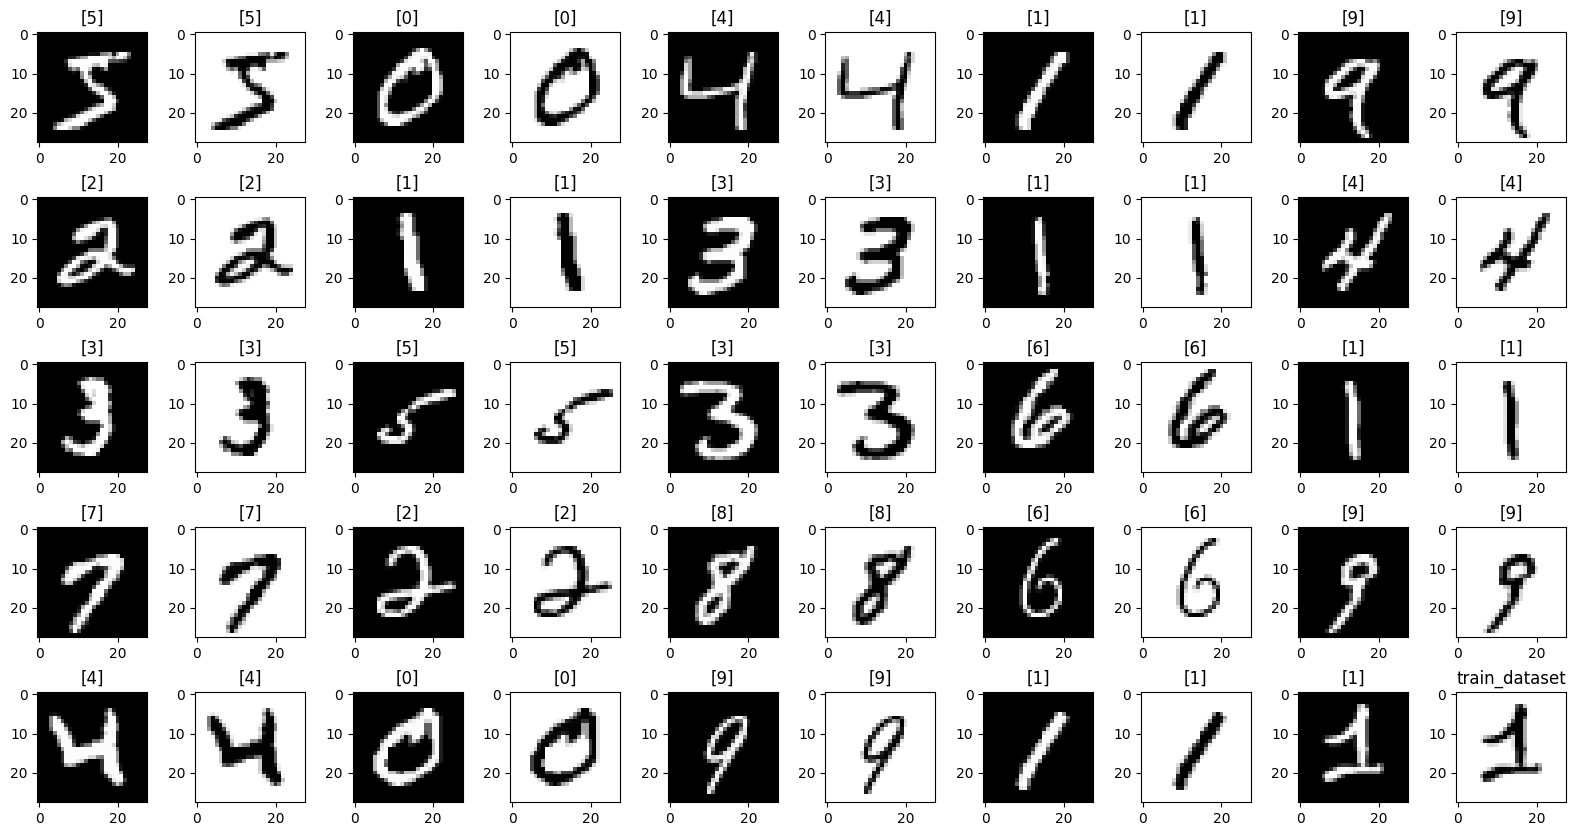

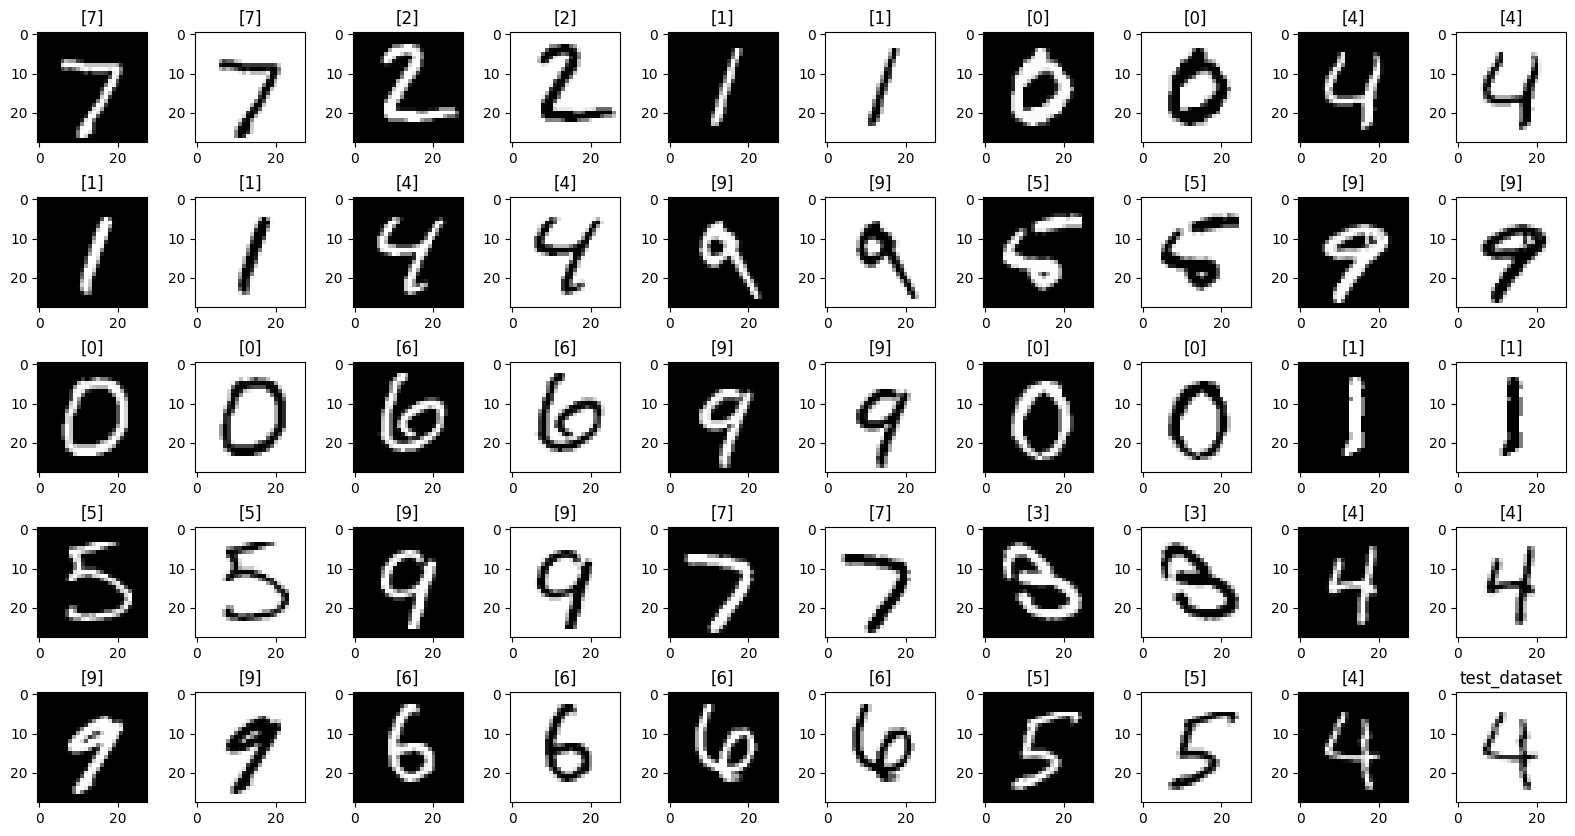

In [9]:
import itertools
import matplotlib
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
for i, item in enumerate(itertools.islice(train_dataset, 0, 50)):
    # print(img, label)
    plt.subplot(5, 10, i+1)
    image, label= item
    plt.title(str(label))
    plt.imshow(image, cmap=matplotlib.cm.gist_gray)

plt.subplots_adjust(hspace=0.5)
plt.title('train_dataset')
plt.show()


plt.figure(figsize=(20, 10))
for i, item in enumerate(itertools.islice(test_dataset, 0, 50)):
    # print(img, label)
    plt.subplot(5, 10, i+1)
    image, label= item
    plt.title(str(label))
    plt.imshow(image, cmap=matplotlib.cm.gist_gray)

plt.subplots_adjust(hspace=0.5)
plt.title('test_dataset')
plt.show()


## 二、网络模型定义
### 1. LeNet
![LeNet-5.png](./assets/LeNet-5.png)

In [13]:
import paddle.nn as nn
import paddle.nn.functional as F

class LeNet(nn.Layer):
    def __init__(self):
        super(LeNet, self).__init__()
        # 定义卷积层，输出特征通道 out_channels 设置为 6，卷积核的大小 kernel_size 为 5，卷积步长 stride=1，padding=2
        self.conv1 = nn.Conv2D(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.max_pool1 = nn.MaxPool2D(kernel_size=2,  stride=2)
        self.conv2 = nn.Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.max_pool2 = nn.MaxPool2D(kernel_size=2, stride=2)
        self.linear1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.linear2 = nn.Linear(in_features=120, out_features=84)
        self.linear3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.flatten(x, start_axis=1, stop_axis=-1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x

paddle.summary(LeNet(), (1, 1, 28, 28))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-7       [[1, 1, 28, 28]]      [1, 6, 28, 28]          156      
  MaxPool2D-7     [[1, 6, 28, 28]]      [1, 6, 14, 14]           0       
   Conv2D-8       [[1, 6, 14, 14]]     [1, 16, 10, 10]         2,416     
  MaxPool2D-8    [[1, 16, 10, 10]]      [1, 16, 5, 5]            0       
   Linear-10         [[1, 400]]            [1, 120]           48,120     
   Linear-11         [[1, 120]]            [1, 84]            10,164     
   Linear-12         [[1, 84]]             [1, 10]              850      
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
-----------------------------------------------------------------------

{'total_params': 61706, 'trainable_params': 61706}

### AlexNet
![AlexNet.png](./assets/AlexNet.png)
![MyAlexNet.png](./assets/MyAlexNet-resized.png)

In [19]:
import paddle
from paddle.nn import Conv2D, MaxPool2D, Linear, Dropout, Layer
import paddle.nn.functional as F

class MyAlexNet(Layer):
    def __init__(self):
        super(MyAlexNet, self).__init__()
        self.conv1 = Conv2D(in_channels=1, out_channels=48 * 2, kernel_size=5, stride=1, padding=2) # 1x28x28 -padding-> 1x32x32 -conv-> (48x2)x28x28
        self.max_pool1 = MaxPool2D(kernel_size=2, stride=2) # (48x2)x14x14
        self.conv2 = Conv2D(in_channels=48 * 2, out_channels=128 * 2, kernel_size=5, stride=1, padding=2) # (48x2)x14x14 -padding-> (48x2)x18x18 -conv-> (128x2)x14x14
        self.max_pool2 = MaxPool2D(kernel_size=2, stride=2) # (128x2)x7x7
        self.conv3 = Conv2D(in_channels=128 * 2, out_channels=192 * 2, kernel_size=3, stride=1, padding=1) # (128x2)x7x7 -padding-> (128x2)x9x9 -conv-> (192x2)x7x7
        self.conv4 = Conv2D(in_channels=192 * 2, out_channels=192 * 2, kernel_size=3, stride=1, padding=1) # (192x2)x7x7 -padding-> (192x2)x9x9 -conv-> (192x2)x7x7
        self.conv5 = Conv2D(in_channels=192 * 2, out_channels=128 * 2, kernel_size=3, stride=1, padding=1) # (192x2)x7x7 -padding-> (192x2)x9x9 -conv-> (128x2)x7x7
        self.max_pool5 = MaxPool2D(kernel_size=3, stride=2) # (128x2)x7x7 -pool-> (128x2)x3x3

        self.fc1 = Linear(in_features=2304, out_features=1024)
        self.drop1 = Dropout(0.5)
        self.fc2 = Linear(in_features=1024, out_features=1024)
        self.drop2 = Dropout(0.5)
        self.fc3 = Linear(in_features=1024, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.max_pool5(x)
        x = paddle.reshape(x, [x.shape[0], -1])
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.drop2(x)
        x = self.fc3(x)
        return x

paddle.summary(MyAlexNet(), (1, 1, 28, 28))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-34      [[1, 1, 28, 28]]     [1, 96, 28, 28]         2,496     
 MaxPool2D-23    [[1, 96, 28, 28]]     [1, 96, 14, 14]           0       
   Conv2D-35     [[1, 96, 14, 14]]     [1, 256, 14, 14]       614,656    
 MaxPool2D-24    [[1, 256, 14, 14]]     [1, 256, 7, 7]           0       
   Conv2D-36      [[1, 256, 7, 7]]      [1, 384, 7, 7]        885,120    
   Conv2D-37      [[1, 384, 7, 7]]      [1, 384, 7, 7]       1,327,488   
   Conv2D-38      [[1, 384, 7, 7]]      [1, 256, 7, 7]        884,992    
 MaxPool2D-25     [[1, 256, 7, 7]]      [1, 256, 3, 3]           0       
   Linear-28        [[1, 2304]]           [1, 1024]          2,360,320   
  Dropout-11        [[1, 1024]]           [1, 1024]              0       
   Linear-29        [[1, 1024]]           [1, 1024]          1,049,600   
  Dropout-12        [[1, 1024]]     

{'total_params': 7134922, 'trainable_params': 7134922}

### VGG
![vgg.png](./assets/vgg.png)

In [19]:
class VGG(paddle.nn.Layer):
    def __init__(self):
        super(VGG, self).__init__()

        in_channels = [1, 64, 128, 256, 512, 512]

        self.conv1_1 = Conv2D(in_channels=in_channels[0], out_channels=in_channels[1], kernel_size=3, padding=1, stride=1)
        self.conv1_2 = Conv2D(in_channels=in_channels[1], out_channels=in_channels[1], kernel_size=3, padding=1, stride=1)

        self.conv2_1 = Conv2D(in_channels=in_channels[1], out_channels=in_channels[2], kernel_size=3, padding=1, stride=1)
        self.conv2_2 = Conv2D(in_channels=in_channels[2], out_channels=in_channels[2], kernel_size=3, padding=1, stride=1)

        self.conv3_1 = Conv2D(in_channels=in_channels[2], out_channels=in_channels[3], kernel_size=3, padding=1, stride=1)
        self.conv3_2 = Conv2D(in_channels=in_channels[3], out_channels=in_channels[3], kernel_size=3, padding=1, stride=1)
        self.conv3_3 = Conv2D(in_channels=in_channels[3], out_channels=in_channels[3], kernel_size=3, padding=1, stride=1)

        self.conv4_1 = Conv2D(in_channels=in_channels[3], out_channels=in_channels[4], kernel_size=3, padding=1, stride=1)
        self.conv4_2 = Conv2D(in_channels=in_channels[4], out_channels=in_channels[4], kernel_size=3, padding=1, stride=1)
        self.conv4_3 = Conv2D(in_channels=in_channels[4], out_channels=in_channels[4], kernel_size=3, padding=1, stride=1)

        self.conv5_1 = Conv2D(in_channels=in_channels[4], out_channels=in_channels[5], kernel_size=3, padding=1, stride=1)
        self.conv5_2 = Conv2D(in_channels=in_channels[5], out_channels=in_channels[5], kernel_size=3, padding=1, stride=1)
        self.conv5_3 = Conv2D(in_channels=in_channels[5], out_channels=in_channels[5], kernel_size=3, padding=1, stride=1)

        self.fc1 = paddle.nn.Sequential(paddle.nn.Linear(512 * 7 * 7, 4096), paddle.nn.ReLU())
        self.drop1_ratio = 0.5
        self.dropout1 = paddle.nn.Dropout(self.drop1_ratio, mode='upscale_in_train')
        self.fc2 = paddle.nn.Sequential(paddle.nn.Linear(4096, 4096), paddle.nn.ReLU())

        self.drop2_ratio = 0.5
        self.dropout2 = paddle.nn.Dropout(self.drop2_ratio, mode='upscale_in_train')
        self.fc3 = paddle.nn.Linear(4096, 10)

        self.relu = paddle.nn.ReLU()
        self.pool = MaxPool2D(stride=2, kernel_size=2)

    def forward(self, x):
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))

        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))

        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))
        x = self.relu(self.conv3_3(x))

        x = self.relu(self.conv4_1(x))
        x = self.relu(self.conv4_2(x))
        x = self.relu(self.conv4_3(x))
        x = self.pool(x)

        x = self.relu(self.conv5_1(x))
        x = self.relu(self.conv5_2(x))
        x = self.relu(self.conv5_3(x))
        x = self.pool(x)

        x = paddle.flatten(x, 1, -1)
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

## 三、训练
### 1. 对优化器的尝试

在 `learning_rate` 为 `0.01`， `batch_size` 为 `64`， `epochs` 为 `20` 的条件下使用了几种不同的优化器

| 优化器 |  acc   |
|:---:|:------:|
|Adam| 0.9607 |
|Adadelta| 0.9729 |
|Lamb| 0.9478 |
|SGD| 0.9878 |
|Momentum|        |

In [26]:
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def draw_model_res_path(dir):
    learn_rates = []
    batch_sizes = []
    losses = []
    accs = []

    files = os.listdir(dir)
    for f in files:
        if not f.endswith('.txt'):
            continue

        res = re.match(r'.*?-.*?-(.*?)-(.*?)-.*', f)
        learn_rate, batch_size = float(res[1]), float(res[2])
        learn_rates.append(learn_rate)
        batch_sizes.append(batch_size)

        with open(f'{dir}/{f}') as _f:
            res = re.findall(r"\{'loss': \[(.*?)], 'acc': (.*?)}", ''.join(_f.readlines()))[0]
            loss, acc = float(res[0]), float(res[1])
            losses.append(loss)
            accs.append(acc)


    df = pd.DataFrame({
        'learn_rate': learn_rates,
        'batch_size': batch_sizes,
        'loss': losses,
        'acc': accs
    })

    df

    name = re.match(r".*/(.*?-.*?)-.*", dir)[1]

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    mat = df.pivot(index='learn_rate', columns='batch_size', values='acc')
    sns.heatmap(mat, cmap='YlGnBu')
    plt.title(f'{name} Acc Heatmap')

    plt.subplot(1, 2, 2)
    mat = df.pivot(index='learn_rate', columns='batch_size', values='loss')
    sns.heatmap(mat, cmap='YlGnBu')
    plt.title(f'{name} Loss Heatmap')
    plt.show()

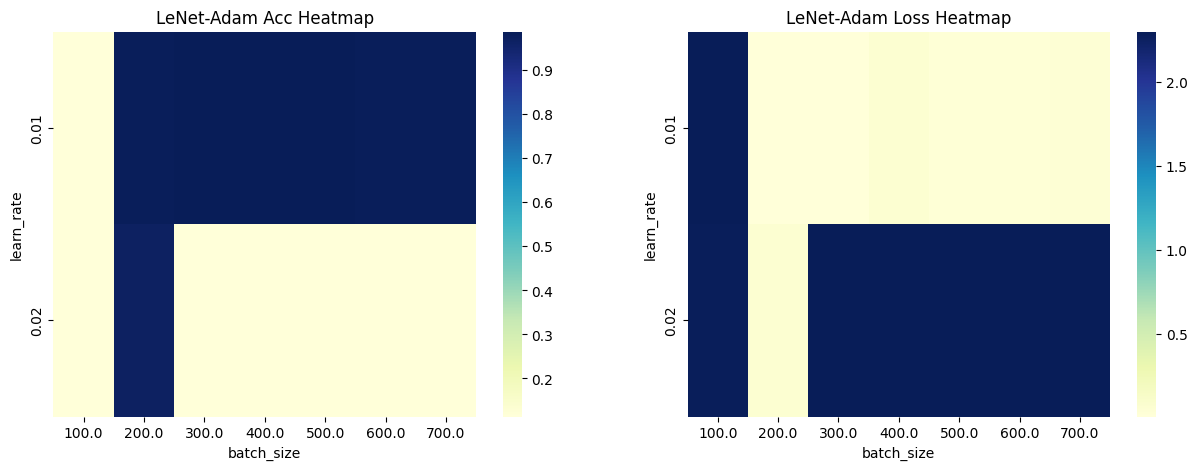

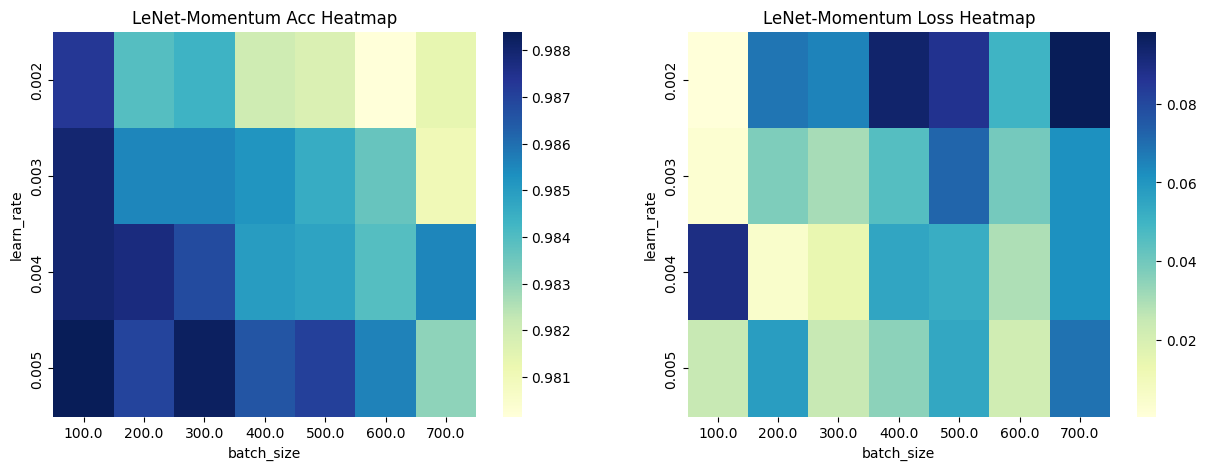

In [27]:
draw_model_res_path('./models/LeNet-Adam-[0.01-0.02]-[100-700]-evaluate')
draw_model_res_path('./models/LeNet-Momentum-[0.002-0.005]-[100-700]-evaluate')

In [20]:
from utils import redirect_stdout

EPOCHS = 20

def train(batch_size, learning_rate):
    with open(f'LeNet-Momentum-{learning_rate}-{batch_size}-train.txt', 'w') as f:
        with redirect_stdout(f):
            # 选择训练网络模型，以LeNet为例
            network = LeNet()
            model = paddle.Model(network)

            def train_model():
                # 使用Momentum优化器
                model.prepare(paddle.optimizer.Momentum(learning_rate=learning_rate, parameters=model.parameters()),
                              paddle.nn.CrossEntropyLoss(),
                              paddle.metric.Accuracy())
                # 模型训练
                model.fit(train_dataset, epochs=EPOCHS, batch_size=batch_size, verbose=1)
                # 保存模型
                model.save(f'./output/Momentum/{learning_rate}/{batch_size}/LeNet-Momentum')

            train_model()